# Cassava Leaf Disease Classification: Exploratory Data Analysis

### 1. Overview


This notebook presents an exploratory data analysis of the Cassava Leaf Disease Classification dataset. Cassava is a crucial staple crop in many African countries, and early detection of diseases is vital for food security. Our goal is to develop a model that can accurately classify cassava leaves into five categories: healthy leaves and four disease classes.

In this analysis, we will:

* Examine the dataset structure

* Visualize sample images from each class

* Analyze the class distribution

* Investigate image properties (size, format, etc.)

* Draw insights to inform our modeling approach

### 2. Getting Started: Importing Libraries and Loading Data

To begin, we'll import the required libraries and display their versions for reproducibility purposes.

In [1]:
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import shutil

In [2]:
print("matplotlib version : ", matplotlib.__version__)

!python --version

matplotlib version :  3.9.2
Python 3.11.0


In this study, we address a critical agricultural challenge in Uganda: the early detection of cassava diseases. Cassava, a vital staple crop in the region, is susceptible to several devastating diseases. Our objective is to develop a robust deep learning model capable of distinguishing between healthy cassava plants and those affected by four distinct diseases. This innovative approach could significantly accelerate the disease identification process, providing farmers with a powerful tool to monitor and maintain the health of their cassava crops efficiently.

In [3]:
data_dir = "data_p2"
train_dir = os.path.join(data_dir, "train")

print("Data directory:", train_dir)

Data directory: data_p2/train


### 3. Examining the Classes

In [4]:
classes = os.listdir(train_dir)
classes

['cassava-healthy',
 'cassava-mosaic-disease-cmd',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-bacterial-blight-cbb']

### 4. Visualizing Sample Images

To better understand the nature of our classification task, we'll examine representative examples from our dataset. Our custom function selects random images from each of the five classes (healthy plants and four disease categories), displaying them with their respective image IDs and labels. This visual analysis helps us appreciate the nuances of the classification challenge and informs our approach to model development.

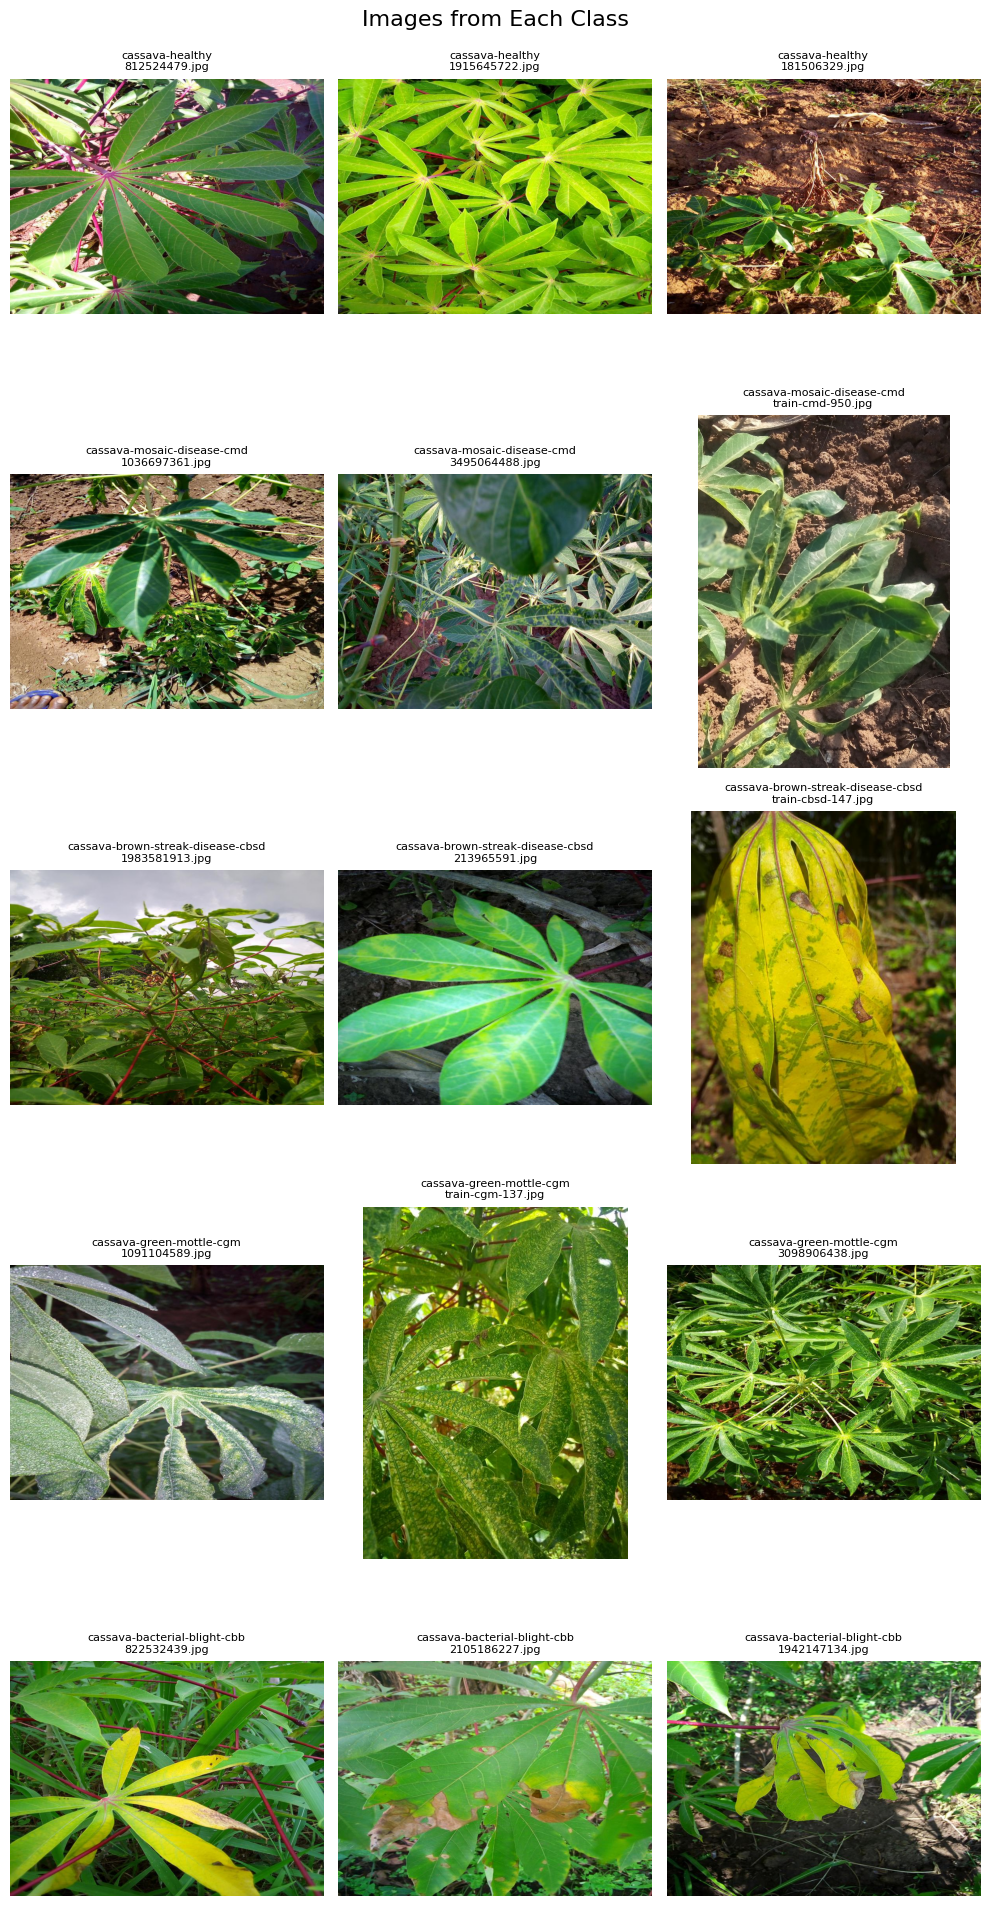

In [5]:
random.seed(42)

# Data directory
data_dir = "data_p2"
train_dir = os.path.join(data_dir, "train")

# Get list of classes
classes = os.listdir(train_dir)

# Set up the plot
fig, axes = plt.subplots(len(classes), 3, figsize=(10, 20))
fig.suptitle("Images from Each Class", fontsize=16)

# Loop through each class
for i, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)
    
    # Randomly select 2 images
    selected_images = random.sample(images, 3)
    
    # Display the images
    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{class_name}\n{img_name}", fontsize=8)

plt.tight_layout()
plt.show()


After visualizing these images, we can observe that some diseases have distinct visual characteristics, while others may be more subtle. This highlights the challenge our model will face in distinguishing between classes, especially for diseases with similar visual symptoms.

### 5. Analyzing Class Distribution

Let's examine the distribution of images across different classes.

In [6]:
# Count images in each class
class_counts = {}
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Print the counts
print("Distribution of images among classes:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Calculate total images
total_images = sum(class_counts.values())
print(f"\nTotal number of images: {total_images}")


Distribution of images among classes:
cassava-healthy: 2863 images
cassava-mosaic-disease-cmd: 3786 images
cassava-brown-streak-disease-cbsd: 3602 images
cassava-green-mottle-cgm: 3129 images
cassava-bacterial-blight-cbb: 1523 images

Total number of images: 14903


Let's visualize the distribution of classes across the dataset, in terms of overall counts.

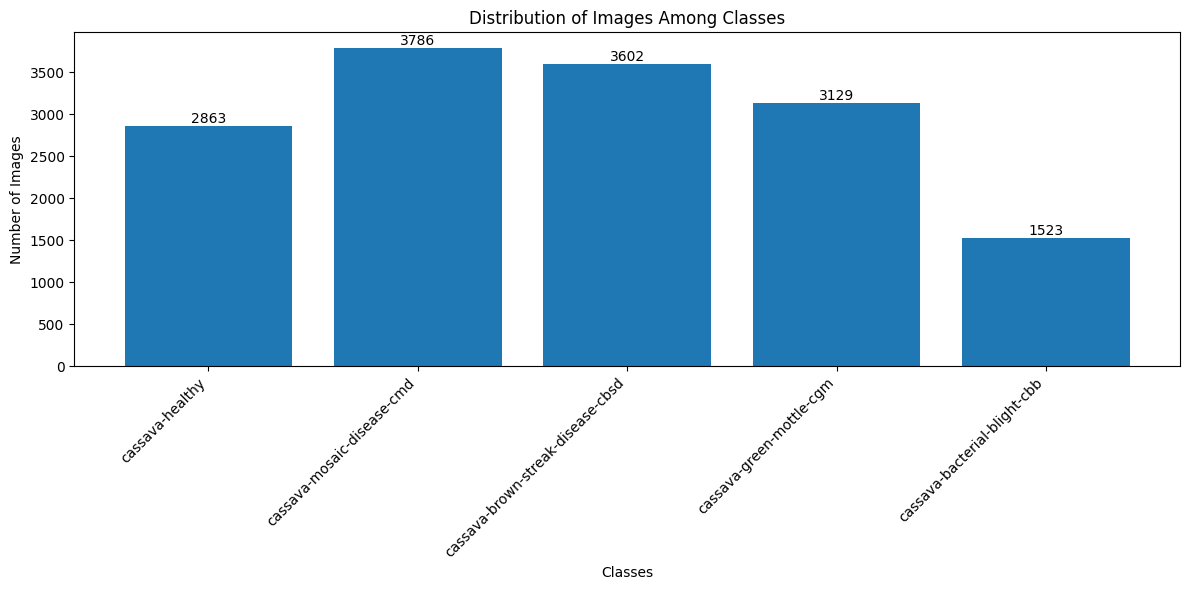

In [7]:
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribution of Images Among Classes")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(class_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Let's visualize the distribution of classes across the dataset, in percentage terms.

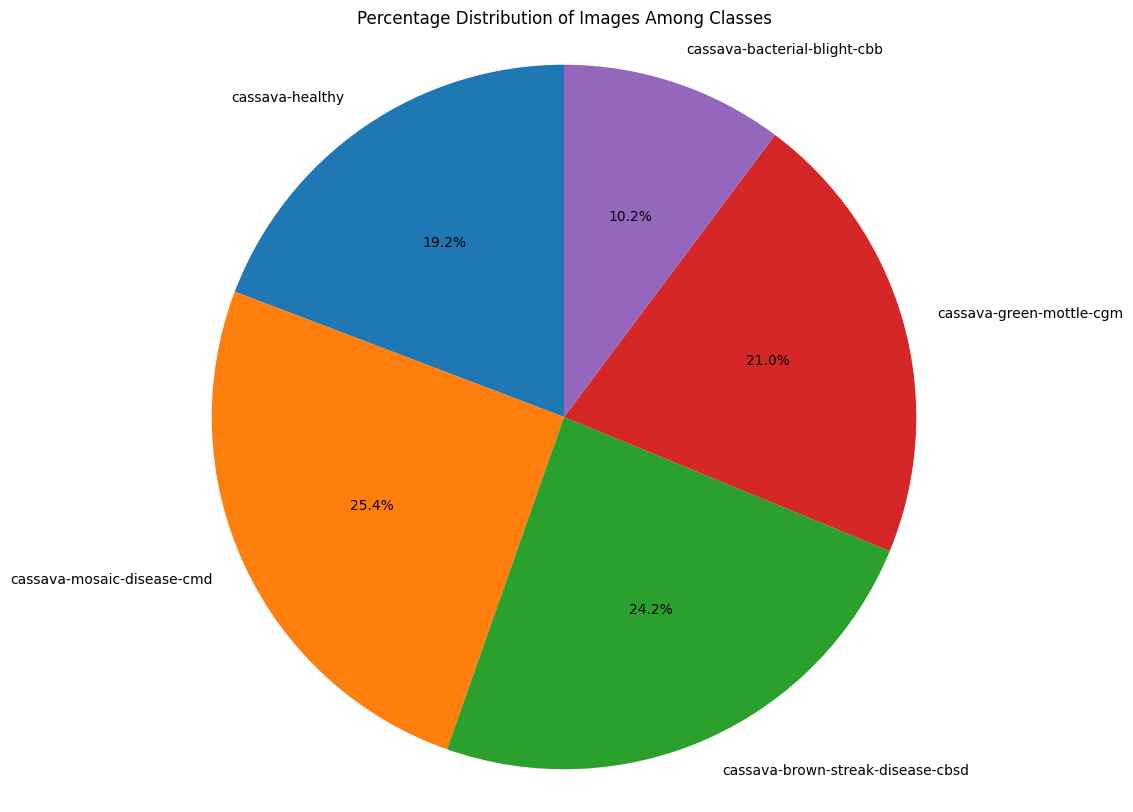

In [8]:
# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Percentage Distribution of Images Among Classes")
plt.axis('equal')
plt.show()


Based on our analysis of class distribution, we observe a notable imbalance across the five categories of cassava leaf conditions. The dataset exhibits a skew towards disease classes, with Cassava Mosaic Disease (CMD) being the most prevalent, followed closely by Cassava Brown Streak Disease (CBSD) and Cassava Green Mottle (CGM). Healthy cassava leaves represent a significant portion of the dataset, but not the majority. Notably, Cassava Bacterial Blight (CBB) is substantially underrepresented, with less than half the instances of the next least common class.

### 6. Under Sampling

The class distribution in our dataset, as observed in the previous analysis, is highly imbalanced. This imbalance can lead to a biased model that disproportionately favors the more prevalent classes, such as Cassava Mosaic Disease (CMD), while underperforming on underrepresented classes like Cassava Bacterial Blight (CBB). This does not accurately reflect real-world scenarios, where all classes are equally important for diagnosis.

To address this issue, we need to balance our dataset. We can either get more images until they're about the same, or remove images from the ones with more images. Since acquiring additional data is not feasible in this case, we will use under-sampling to balance the dataset. The function below implements this approach by reducing the number of samples in the larger classes to match the size of the smallest class. While under-sampling may result in some loss of information, it ensures that our model is trained on a balanced dataset, thereby mitigating bias and improving its ability to generalize across all classes.

In [9]:
undersampled_dir = os.path.join(data_dir, "train_undersampled")


In [10]:
# Find the minimum class count
min_count = min(class_counts.values())

print(f"Undersampling all classes to {min_count} images")

# Create undersampled directory
if not os.path.exists(undersampled_dir):
    os.makedirs(undersampled_dir)

# Perform undersampling
for class_name in classes:
    src_dir = os.path.join(train_dir, class_name)
    dst_dir = os.path.join(undersampled_dir, class_name)
    
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    
    # Get all image files
    all_files = os.listdir(src_dir)
    
    # Randomly select min_count files
    selected_files = random.sample(all_files, min_count)
    
    # Copy selected files to the new directory
    for file in selected_files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, file)
        shutil.copy2(src_path, dst_path)

# Verify undersampled dataset
undersampled_counts = {}
for class_name in classes:
    class_dir = os.path.join(undersampled_dir, class_name)
    undersampled_counts[class_name] = len(os.listdir(class_dir))

print("\nUndersampled class distribution:")
for class_name, count in undersampled_counts.items():
    print(f"{class_name}: {count} images")

total_undersampled = sum(undersampled_counts.values())
print(f"\nTotal images after undersampling: {total_undersampled}")


Undersampling all classes to 1523 images

Undersampled class distribution:
cassava-healthy: 1523 images
cassava-mosaic-disease-cmd: 1523 images
cassava-brown-streak-disease-cbsd: 1523 images
cassava-green-mottle-cgm: 1523 images
cassava-bacterial-blight-cbb: 1523 images

Total images after undersampling: 7615


Let's visualize the distribution of classes across the undersampled dataset, in terms of overall counts.

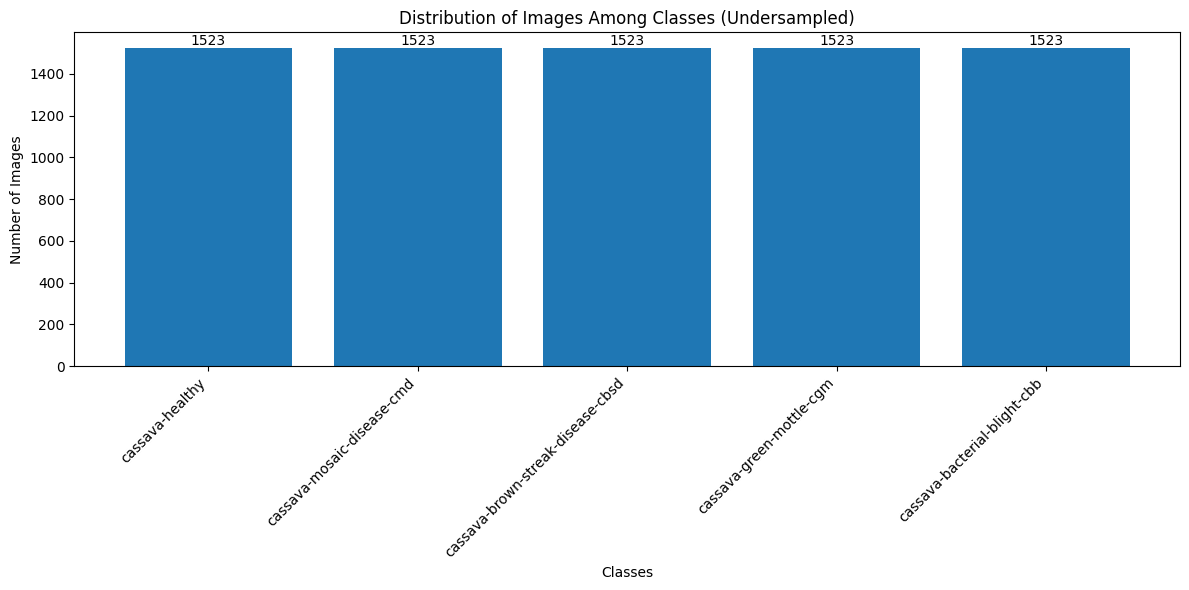

In [11]:
# Count images in each class
class_counts = {}
for class_name in classes:
    class_dir = os.path.join(undersampled_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribution of Images Among Classes (Undersampled)")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(class_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()


### 7. Conclusion and Key Takeaways


Based on this exploratory data analysis of the Cassava Leaf Disease Classification dataset, we can draw the following conclusions:-

**Dataset Composition**:
The dataset comprises 14,903 images across five classes: four disease categories and one healthy class.
All images are in .jpg format, but they vary in size, which will require standardization during preprocessing.

**Class Distribution**:
We observed a significant class imbalance in the dataset. Cassava Mosaic Disease (CMD) is the most prevalent class with 3,786 images. Cassava Bacterial Blight (CBB) is substantially underrepresented with only 1,523 images. The remaining classes (Healthy, CBSD, and CGM) fall between these extremes.

**Addressing Class Imbalance**:
To mitigate the imbalance, we've decided to implement under-sampling. This approach will reduce the number of samples in larger classes to match the size of the smallest class (CBB with 1,523 images). While this results in some data loss, it ensures a balanced training set, reducing potential bias in our model.

**Visual Challenges**:
The random image visualization revealed subtle differences between some disease classes. This highlights the complexity of the classification task and the need for a sophisticated model capable of capturing nuanced features.

Key Takeaways and Next Steps:-

**Data Preprocessing**:
Implement image size standardization to ensure uniform input to our model. Apply the under-sampling technique to balance the classes.

**Model Considerations**:
Choose a model architecture capable of capturing subtle differences between disease classes.